Mo Salah had an exceptional season winning the PFA awards, Golden boot and finished with 13 assists making him assist king of 2021-22 season. This is his shotmap

In [1]:
# Import libraries, packages and modules

import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from highlight_text import fig_text
from matplotlib.patches import Arc

from mplsoccer import Pitch, VerticalPitch
import numpy as np

###  Scraping Salah shots
We start by scraping using BeautifulSoup the career shots made by Mo Salah

In [2]:
# Entering Mo Salah ID link
link = "https://understat.com/player/1250"
res = requests.get(link)
soup = BeautifulSoup(res.content,'lxml')
scripts = soup.find_all('script')

# Get the grouped stats data, it's the second script executed in order
strings = scripts[3].string

# Getting rid of unnecessary characters from json data
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')
data = json.loads(json_data)

In [3]:
# Create pandas data frame
data = pd.DataFrame(data)

In [4]:
# Select specific season to analyze
data = data.loc[data['season'] == '2021']

In [5]:
shots = pd.DataFrame(data) # Mo Salah shot data

### Changing data type
shots['xG'] = shots['xG'].astype('float64')
shots['X'] = shots['X'].astype('float64')
shots['Y'] = shots['Y'].astype('float64')

### Adjusting shots data to pitch dimensions
Understat data is measured at 100x100 ,  we therefore have to adapt Understat's dimensions to our pitch and also keep in mind that the X and Y column values are between 0 and 1 so let's multiply by 100 

In [6]:
shots['X1'] = (shots['X']/100)*105*100
shots['Y1'] = (shots['Y']/100)*68*100
# Original X and Y
shots['X'] = (shots['X']/100)*105*100
shots['Y'] = (shots['Y']/100)*68*100

### Creating dictionaries
creating dictionaries to use them later as text for the shotmaps, it's definitely easier tha calling them as series or series values such as " shots[shots['result']=='ShotOnPost']["xG"].values " 

In [7]:
total_shots = shots[shots.columns[0]].count().tolist()
xGcum = np.round(max(np.cumsum(shots['xG'])),3).tolist()
xG_per_shot = np.round(max(np.cumsum(shots['xG']))/(shots[shots.columns[0]].count()),3).tolist()
goal = shots[shots['result']=='Goal']
shot_on_post = shots[shots['result']=='ShotOnPost']
blocked_shot = shots[shots['result']=='BlockedShot']
saved_shot = shots[shots['result']=='SavedShot']
missed_shot = shots[shots['result']=='MissedShot']
goals = goal[goal.columns[0]].count().tolist()

### Create a function to draw football pitches

In [8]:
# Setting dimensions, colour, orientation of football pitch
def football_pitch(x_min=0, x_max=105,
               y_min=0, y_max=68,
               pitch_color="#f0f0f0",
               line_color='black',
               line_thickness=1.5,
               point_size=20,
               orientation="horizontal",
               aspect="full",
               axis='off',
               ax=None
               ):

    if not ax:
        raise TypeError("This function is intended to be used with an existing fig and ax in order to allow flexibility in plotting of various sizes and in subplots.")


    if orientation.lower().startswith("h"):
        first = 0
        second = 1
        arc_angle = 0

        if aspect == "half":
            ax.set_xlim(x_max / 2, x_max + 5)

    elif orientation.lower().startswith("v"):
        first = 1
        second = 0
        arc_angle = 90

        if aspect == "half":
            ax.set_ylim(x_max / 2, x_max + 5)

    
    else:
        raise NameError("You must choose one of horizontal or vertical")
    
    ax.axis(axis)

    rect = plt.Rectangle((x_min, y_min),
                         x_max, y_max,
                         facecolor=pitch_color,
                         edgecolor="none",
                         zorder=-2)

    ax.add_artist(rect)

    x_conversion = x_max / 100
    y_conversion = y_max / 100

    pitch_x = [0,5.8,11.5,17,50,83,88.5,94.2,100] # x dimension markings
    pitch_x = [x * x_conversion for x in pitch_x]

    pitch_y = [0, 21.1, 36.6, 50, 63.2, 78.9, 100] # y dimension markings
    pitch_y = [x * y_conversion for x in pitch_y]

    goal_y = [45.2, 54.8] # goal posts
    goal_y = [x * y_conversion for x in goal_y]

    # side and goal lines
    lx1 = [x_min, x_max, x_max, x_min, x_min]
    ly1 = [y_min, y_min, y_max, y_max, y_min]

    # outer box
    lx2 = [x_max, pitch_x[5], pitch_x[5], x_max]
    ly2 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    lx3 = [0, pitch_x[3], pitch_x[3], 0]
    ly3 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    # goals
    lx4 = [x_max, x_max+2, x_max+2, x_max]
    ly4 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    lx5 = [0, -2, -2, 0]
    ly5 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    # 6 yard box
    lx6 = [x_max, pitch_x[7], pitch_x[7], x_max]
    ly6 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]

    lx7 = [0, pitch_x[1], pitch_x[1], 0]
    ly7 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]


    # Halfline, penalty spots, and kickoff spot
    lx8 = [pitch_x[4], pitch_x[4]]
    ly8 = [0, y_max]

    lines = [
        [lx1, ly1],
        [lx2, ly2],
        [lx3, ly3],
        [lx4, ly4],
        [lx5, ly5],
        [lx6, ly6],
        [lx7, ly7],
        [lx8, ly8],
        ]

    points = [
        [pitch_x[6], pitch_y[3]],
        [pitch_x[2], pitch_y[3]],
        [pitch_x[4], pitch_y[3]]
        ]

    circle_points = [pitch_x[4], pitch_y[3]]
    arc_points1 = [pitch_x[6], pitch_y[3]]
    arc_points2 = [pitch_x[2], pitch_y[3]]


    for line in lines:
        ax.plot(line[first], line[second],
                color=line_color,
                lw=line_thickness,
                zorder=-1)

    for point in points:
        ax.scatter(point[first], point[second],
                   color=line_color,
                   s=point_size,
                   zorder=-1)

    circle = plt.Circle((circle_points[first], circle_points[second]),
                        x_max * 0.088,
                        lw=line_thickness,
                        color=line_color,
                        fill=False,
                        zorder=-1)

    ax.add_artist(circle)

    arc1 = Arc((arc_points1[first], arc_points1[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=128.75,
               theta2=231.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc1)

    arc2 = Arc((arc_points2[first], arc_points2[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=308.75,
               theta2=51.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc2)

    ax.set_aspect("equal")

    return ax

### Shootmap : Mo Salah 2021-22 shots
Let's plot 2021-22 shots by Mo Salah , representing the xG quality shots the qaulity of the shots with varing dimensions. Bigger circle, higher quality.

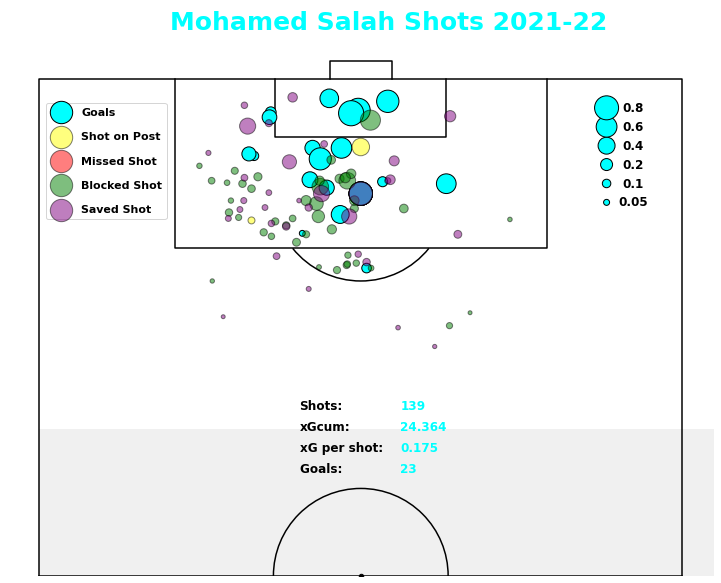

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
football_pitch(orientation="vertical",aspect="half",line_color="black",ax=ax,axis="off")




#Drawing a full pitch horizontally
z = goal['xG'].tolist()
z1 = [500 * i for i in z] # This is to scale the "xG" values for plotting
color = {'Goal':'cyan', 'MissedShots':'red', 'BlockedShot':'tomato', 'SavedShot':'black', 'ShotOnPost':'Yellow'}
## markers = {'Goal':'Star', 'MissedShots':'X', 'BlockedShot':'O', 'SavedShot':'V', 'ShotOnPost':'S'}

# Plotting the goals, the missed chances shot on post etc 
plt.scatter(y=goal["X1"],x=goal["Y1"],s=goal['xG']*720, marker='o',color='cyan',edgecolors="black",label='Goals')
plt.scatter(y=shot_on_post["X1"],x=shot_on_post["Y1"],s=shot_on_post['xG']*720, marker='o',color='yellow',edgecolors="black",label='Shot on Post',alpha=0.5)
plt.scatter(y=missed_shot["X1"],x=missed_shot["Y1"],s=missed_shot['xG']*720, marker='o',color='red',edgecolors="black",label='Missed Shot',alpha=0.5)
plt.scatter(y=blocked_shot["X1"],x=blocked_shot["Y1"],s=blocked_shot['xG']*720, marker='o',color='green',edgecolors="black",label='Blocked Shot',alpha=0.5)
plt.scatter(y=saved_shot["X1"],x=saved_shot["Y1"],s=saved_shot['xG']*720, marker='o',color='purple',edgecolors="black",label='Saved Shot',alpha=0.5)
#legend 
# another way to do it 
#ax.legend(loc='upper center', bbox_to_anchor= (0.13, 0.87),
            #borderaxespad=0, frameon=False)
legend = ax.legend(loc="upper center",bbox_to_anchor= (0.14, 0.88),labelspacing=1.3,prop={'weight':'bold','size':11})
legend.legendHandles[0]._sizes = [500]
legend.legendHandles[1]._sizes = [500]
legend.legendHandles[2]._sizes = [500]
legend.legendHandles[3]._sizes = [500]
legend.legendHandles[4]._sizes = [500]

# xG Size 
mSize = [0.05,0.10,0.2,0.4,0.6,0.8]
mSizeS = [720 * i for i in mSize]
mx = [60,60,60,60,60,60]
my = [92,94,96,98,100,102]
plt.scatter(mx,my,s=mSizeS,facecolors="cyan", edgecolor="black")
for i in range(len(mx)):
    plt.text(mx[i]+ 2.8, my[i], mSize[i], fontsize=12, color="black",ha="center", va="center",fontweight='bold')
# Annotation text
fig_text(0.38,0.91, s="Mohamed Salah Shots 2021-22", fontsize = 25, fontweight = "bold",c='cyan')
fig_text(0.47,0.37, s="Shots:\n\nxGcum:\n\nxG per shot:\n\nGoals: ", fontsize = 12, fontweight = "bold",c='black')
fig_text(0.54,0.37, s="<{}\n\n{}\n\n{}\n\n{}>".format(total_shots,xGcum,xG_per_shot,goals), fontsize = 12, fontweight = "bold",c='cyan');

### Mo Salah Goals



In [10]:
head = goal[goal['shotType']=='Head']
left_foot = goal[goal['shotType']=='LeftFoot']
right_foot = goal[goal['shotType']=='RightFoot']
head = head[head.columns[0]].count().tolist()
right_foot = right_foot[right_foot.columns[0]].count().tolist()
left_foot = left_foot[left_foot.columns[0]].count().tolist()

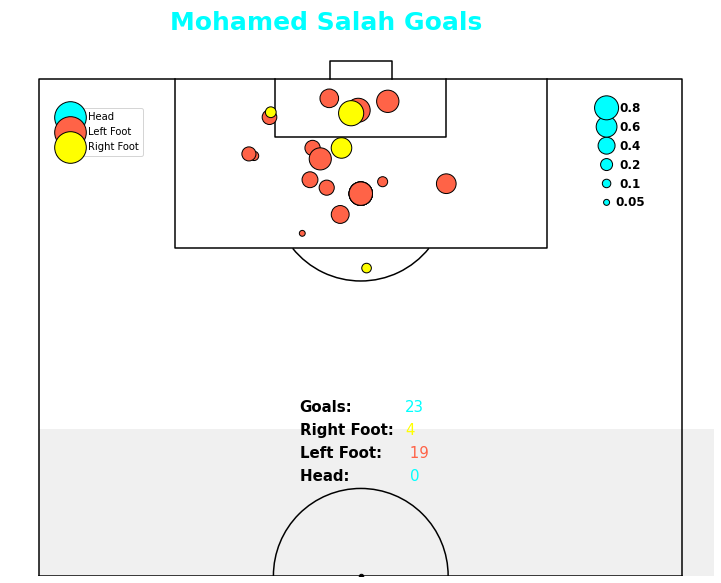

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
football_pitch(orientation="vertical",aspect="half",line_color="black",ax=ax,axis="off")

#Drawing a full pitch horizontally
z = goal['xG'].tolist()
z1 = [500 * i for i in z] # This is to scale the "xG" values for plotting
colors = {'Goal':'cyan', 'MissedShots':'red', 'BlockedShot':'tomato', 'SavedShot':'black', 'ShotOnPost':'Yellow'}
## markers = {'Goal':'Star', 'MissedShots':'X', 'BlockedShot':'O', 'SavedShot':'V', 'ShotOnPost':'S'}

# Plotting the goals, the missed chances shot on post etc 
plt.scatter(y=goal[goal['shotType']=='Head']['X1'],x=goal[goal['shotType']=='Head']['Y1'],s=goal[goal['shotType']=='Head']['xG']*720, marker='o',color='cyan',edgecolors="black",label='Head')
plt.scatter(y=goal[goal['shotType']=='LeftFoot']['X1'],x=goal[goal['shotType']=='LeftFoot']['Y1'],s=goal[goal['shotType']=='LeftFoot']['xG']*720, marker='o',color='tomato',edgecolors="black",label='Left Foot')
plt.scatter(y=goal[goal['shotType']=='RightFoot']['X1'],x=goal[goal['shotType']=='RightFoot']['Y1'],s=goal[goal['shotType']=='RightFoot']['xG']*720, marker='o',color='yellow',edgecolors="black",label='Right Foot')

# xG Size
mSize = [0.05,0.10,0.2,0.4,0.6,0.8]
mSizeS = [720 * i for i in mSize]
mx = [60,60,60,60,60,60]
my = [92,94,96,98,100,102]
plt.scatter(mx,my,s=mSizeS,facecolors="cyan", edgecolor="black")
for i in range(len(mx)):
    plt.text(mx[i]+ 2.5, my[i], mSize[i], fontsize=12, color="black",ha="center", va="center",fontweight='bold')

# Pitch map text
fig_text(0.38,0.91, s="Mohamed Salah Goals\n", fontsize = 25, fontweight = "bold",c='cyan')
fig_text(0.47,0.37, s="Goals:\n\nRight Foot:\n\nLeft Foot:\n\nHead: ", fontsize = 15, fontweight = "bold",c='black')
fig_text(0.54,0.37, s=" <{}>\n\n <{}>\n\n < {}>\n\n  <{}>".format(goals,right_foot,left_foot,head), fontsize = 15, fontweight = "light",highlight_textprops=[{"color":'cyan'}, {'color':"yellow"}, {'color':"tomato"}, {'color':"cyan"}])

# Legend
legend = ax.legend(loc="upper center",bbox_to_anchor= (0.13, 0.87))
legend.legendHandles[0]._sizes = [1000]
legend.legendHandles[1]._sizes = [1000]
legend.legendHandles[2]._sizes = [1000]

### References
https://www.kaggle.com/code/josegabrielgonzalez/understat-series-shotmaps/notebook

https://www.youtube.com/watch?v=IsR5FrjNmro&t=232s